# Mølmer–Sørensen Gate Simulator
The Molmer-Sorensen Hamiltonian (for one ion) is defubed as the sum of the red and blue sideband interactions with symmetric detunning
$$H_{ms}(t) = -i\frac{\eta\Omega}{2}(\sigma_+e^{i\phi_s}-\sigma_-e^{-i\phi_s})(a e^{-i\delta t} + a^{\dagger}e^{i\delta t})$$
However, it is more convinient to use the original form of $\hat{H} = \hat{R}+\hat{B}$, where writes $\delta_r$, $\delta_b$, $\phi_r$, and $\phi_b$ explicitly.
$$-i\frac{\eta}{2}(\Omega_r\sigma_+ae^{-i\delta_r t}e^{i\phi_r}-\Omega_r\sigma_-a^{\dagger}e^{i\delta_r t}e^{-i\phi_r}+ \Omega_b\sigma_+a^{\dagger}e^{-i\delta_b t}e^{i\phi_b} -
\Omega_b\sigma_-ae^{i\delta_b t}e^{-i\phi_b})$$

In [1]:
import qutip as qt
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import datetime
from numpy import linalg
#import pandas as pd
%matplotlib inline

## Modulated MS Gate
$\Omega_r = \Omega_b$ -> Every motional mode commutes

In [2]:
class ModulatedMSGate(object):
    def __init__(self, n_max = 10):
        self.gate_time = 0.50
        self.pulse_seq = -np.ones(2)*2*2*np.pi
        self.mode_freq = np.zeros(1)*2*2*np.pi
        self.rabi_freq = 1*2*np.pi
        self.ion0 = 0
        self.ion1 = 1
        self.n_max = n_max
        self.posi = np.array([-1.,1.])
        self.eta = self._get_coupling()*2/np.sqrt(2)
        self.freq_sol = np.ones(1)*-1
        self.phase_sol = np.ones(2)*self.gate_time*2*np.pi
        self.phase_list = np.arange(2)*self.gate_time*2*np.pi
        self.amp_list = np.ones(2)
    
    def set_attr_fm(self,
                    ion0,
                    ion1,
                    gate_time,
                    freq_sol,
                    rabi_freq,
                    mode_freq,
                    posi):
        self.ion0 = ion0
        self.ion1 = ion1
        self.gate_time = gate_time
        self.freq_sol = freq_sol
        self.pulse_seq = freq_sol#np.append(freq_sol, np.flip(freq_sol)) # better for optimization
        self.amp_list = np.ones(self.pulse_seq.shape[0])
        self.mode_freq = mode_freq
        self.rabi_freq = rabi_freq
        self.posi = posi
        self.eta = self._get_coupling()
        self.phase_list = self._get_phase_fm(self.pulse_seq, self.gate_time/self.pulse_seq.shape[0])

    def _get_phase_fm(self, freq_list, delta_t):
        return np.append(0.0,(freq_list.cumsum()[:-1]-freq_list[1:]*np.arange(1,freq_list.shape[0]))*delta_t)
    
    def _get_coupling(self, beta = 9.48):
        posi = self.posi
        n = posi.shape[0] # number of ions
        A = np.zeros([n, n])
        for i in range(n):
            for j in range(n):
                if i == j:
                    A[i][j] = beta**2 - np.sum(np.abs(posi[j]-posi[:j])**(-3)) - np.sum(np.abs(posi[j]-posi[j+1:])**(-3))
                else:
                    A[i][j] = 1. / np.abs(posi[i]-posi[j]) ** 3
        w, v = linalg.eig(A)
        idx = w.argsort()  
        v = v[:,idx]
        return v
    
    def _hamiltonian(self, mode_id ,step_id):
        
        eta = 1
        ion0 = self.ion0
        ion1 = self.ion1
        pulse = self.pulse_seq
        mode_freq = self.mode_freq
        phase_list = self.phase_list
        b = self.eta
        mode = mode_id
        Nmax = self.n_max

        delta = (pulse[step_id] - mode_freq[mode_id])

        delta_r = np.array([delta,delta])
        delta_b = np.array([-delta,-delta])
        
        omega_r = np.array([self.rabi_freq,self.rabi_freq])*self.amp_list[step_id]
        omega_b = np.array([self.rabi_freq,self.rabi_freq])*self.amp_list[step_id]
        
        phi_r   = -phase_list[step_id]# + (config)**0*delta_phi 
        phi_b   = -phi_r# + (config)**1*delta_phi

        H0 = -1j*b[ion0, mode]*eta/2*omega_r[0]*np.exp(1j*phi_r)*qt.tensor(qt.sigmap(),qt.qeye(2),qt.destroy(Nmax))
        def H0_coeff(t,args):
            return np.exp(-1j*delta_r[0]*t)

        H1 = 1j*b[ion0, mode]*eta/2*omega_r[0]*np.exp(-1j*phi_r)*qt.tensor(qt.sigmam(),qt.qeye(2),qt.create(Nmax))
        def H1_coeff(t,args):
            return np.exp(1j*delta_r[0]*t)

        H2 = -1j*b[ion0, mode]*eta/2*omega_b[0]*np.exp(1j*phi_b)*qt.tensor(qt.sigmap(),qt.qeye(2),qt.create(Nmax))
        def H2_coeff(t,args):
            return np.exp(-1j*delta_b[0]*t)

        H3 = 1j*b[ion0, mode]*eta/2*omega_b[0]*np.exp(-1j*phi_b)*qt.tensor(qt.sigmam(),qt.qeye(2),qt.destroy(Nmax))
        def H3_coeff(t,args):
            return np.exp(1j*delta_b[0]*t)

        H4 = -1j*b[ion1, mode]*eta/2*omega_r[1]*np.exp(1j*phi_r)*qt.tensor(qt.qeye(2),qt.sigmap(),qt.destroy(Nmax))
        def H4_coeff(t,args):
            return np.exp(-1j*delta_r[1]*t)

        H5 = 1j*b[ion1, mode]*eta/2*omega_r[1]*np.exp(-1j*phi_r)*qt.tensor(qt.qeye(2),qt.sigmam(),qt.create(Nmax))
        def H5_coeff(t,args):
            return np.exp(1j*delta_r[1]*t)

        H6 = -1j*b[ion1, mode]*eta/2*omega_b[1]*np.exp(1j*phi_b)*qt.tensor(qt.qeye(2),qt.sigmap(),qt.create(Nmax))
        def H6_coeff(t,args):
            return np.exp(-1j*delta_b[1]*t)

        H7 = 1j*b[ion1, mode]*eta/2*omega_b[1]*np.exp(-1j*phi_b)*qt.tensor(qt.qeye(2),qt.sigmam(),qt.destroy(Nmax))
        def H7_coeff(t,args):
            return np.exp(1j*delta_b[1]*t)
        
        return [[H0,H0_coeff],
                [H1,H1_coeff],
                [H2,H2_coeff],
                [H3,H3_coeff],
                [H4,H4_coeff],
                [H5,H5_coeff],
                [H6,H6_coeff],
                [H7,H7_coeff]]
    
    # Motion modes commute
    def _get_spin(self, s0, nth, Gamma, coherence_t, Nsample, verbose, gateNum):
        gate_time = self.gate_time
        pulse = self.pulse_seq
        Nmax = self.n_max
        tau = coherence_t
        
        if not Gamma:
            Gamma = np.zeros(self.mode_freq.shape[0])
            
        c_ops = []
#         c_ops = [qt.tensor(qt.tensor(qt.qeye(2),qt.qeye(2)), np.sqrt(Gamma[i]*(nth[i]+1))*qt.destroy(Nmax)),
#                          qt.tensor(qt.tensor(qt.qeye(2),qt.qeye(2)), np.sqrt(Gamma[i]*nth[i])*qt.create(Nmax))]
#         if tau != 0:
#             c_ops.append(qt.tensor(qt.qeye(2),qt.qeye(2),np.sqrt(2/tau)*qt.create(Nmax)*qt.destroy(Nmax)))
            
        s_init_0 = qt.tensor(qt.ket2dm(qt.tensor(qt.fock(2,0),qt.fock(2,0))),qt.thermal_dm(Nmax,nth[0]))
        t = np.linspace(0,gate_time,Nsample)
        
        t_step = gate_time/pulse.shape[0]
        t_list = []
        for i in range(pulse.shape[0]):
            t_list.append(np.linspace(i*t_step, (i+1)*t_step, Nsample))
        for k in range(gateNum):
            if k == 0:
                s_init = s_init_0
#-----------------------------------------------------------------------------------------------------------
            for i in range(pulse.shape[0]):
                H = []
                for j in range(self.mode_freq.shape[0]):
                    H += self._hamiltonian(mode_id=j, step_id=i)
                output = qt.mesolve(H, s_init, t_list[i], c_ops, [])
                s_init = output.states[-1]
#-----------------------------------------------------------------------------------------------------------
#             for i in range(self.mode_freq.shape[0]):
#                 for j in range(pulse.shape[0]):
#                     H = self._hamiltonian(mode_id = i, step_id=j)
#                     output = qt.mesolve(H,s_init,t_list[j],c_ops,[])
#                     s_init = output.states[-1]
#                 if i < self.mode_freq.shape[0] - 1:
#                     s_init = qt.tensor(output.states[-1].ptrace([0,1]),qt.thermal_dm(Nmax,nth[i+1]))
#-----------------------------------------------------------------------------------------------------------
        spin = output.states[-1].ptrace([0,1])
        return spin.full()
    
    def get_spin_fm(self, nth=[], Gamma=[], coherence_t=0, Nsample=10, verbose=True, gateNum=1):
        if not nth:
            nth = np.zeros(self.mode_freq.shape[0])
        s0 = qt.tensor(qt.ket2dm(qt.tensor(qt.fock(2,0),qt.fock(2,0))),qt.thermal_dm(self.n_max,nth[0]))
        return self._get_spin(s0, nth, Gamma, coherence_t, Nsample, verbose, gateNum)
    
    def _get_fidelity(self, s0, nth, Gamma, coherence_t, Nsample, verbose):
        gate_time = self.gate_time
        pulse = self.pulse_seq
        Nmax = self.n_max
        tau = coherence_t
        
        if not Gamma:
            Gamma = np.zeros(self.mode_freq.shape[0])
        
        s_init = qt.tensor(qt.ket2dm(qt.tensor(qt.fock(2,0),qt.fock(2,0))),qt.thermal_dm(Nmax,nth[0]))
        t = np.linspace(0,gate_time,Nsample)
        
        t_step = gate_time/pulse.shape[0]
        t_list = []
        for i in range(pulse.shape[0]):
            t_list.append(np.linspace(i*t_step, (i+1)*t_step, Nsample))

        for i in range(self.mode_freq.shape[0]):
            for j in range(pulse.shape[0]):
                H = self._hamiltonian(mode_id = i, step_id=j)
                c_ops = []
#                 c_ops = [qt.tensor(qt.tensor(qt.qeye(2),qt.qeye(2)), np.sqrt(Gamma[i]*(nth[i]+1))*qt.destroy(Nmax)),
#                      qt.tensor(qt.tensor(qt.qeye(2),qt.qeye(2)), np.sqrt(Gamma[i]*nth[i])*qt.create(Nmax))]
#                 if tau != 0:
#                     c_ops.append(qt.tensor(qt.qeye(2),qt.qeye(2),np.sqrt(2/tau)*qt.create(Nmax)*qt.destroy(Nmax)))
                output = qt.mesolve(H,s_init,t_list[j],c_ops,[])
                s_init = output.states[-1]
#                 if verbose:
#                     print('.', end='')
#             if verbose:
#                 print('\n', end='')
            if i < self.mode_freq.shape[0] - 1:
                s_init = qt.tensor(output.states[-1].ptrace([0,1]),qt.thermal_dm(Nmax,nth[i+1]))
        spin = output.states[-1].ptrace([0,1])
        print(spin)
        final = 0.5*qt.ket2dm(qt.basis(4,0)-1j*qt.basis(4,3))
        return qt.fidelity(qt.Qobj(spin.full()),final)
    
    def get_fidelity_fm(self, nth = [], Gamma = [], coherence_t = 0, Nsample = 10, verbose = True):
        if not nth:
            nth = np.zeros(self.mode_freq.shape[0])
        s0 = qt.tensor(qt.ket2dm(qt.tensor(qt.fock(2,0),qt.fock(2,0))),qt.thermal_dm(self.n_max,nth[0]))
        return self._get_fidelity(s0, nth, Gamma, coherence_t, Nsample, verbose)
    
    def _ps_x(self, state):
        x = 1/np.sqrt(2)*(qt.destroy(self.n_max)+qt.create(self.n_max))
        state_ptr = state.ptrace([2])
        x_expect = np.real((state_ptr*x).tr())
        return x_expect

    def _ps_p(self, state):
        p = 1j/np.sqrt(2)*(qt.create(self.n_max)-qt.destroy(self.n_max))
        state_ptr = state.ptrace([2])
        p_expect = np.real((state_ptr*p).tr())
        return p_expect
    
    
    def get_trajectory(self, nth = 0, Gamma = 0, coherence_t = 0, Nsample = 100):
        v_phase_plot_x = np.vectorize(self._ps_x)
        v_phase_plot_p = np.vectorize(self._ps_p)
        nth = nth
        Gamma = Gamma
        gate_time = self.gate_time
        pulse = self.pulse_seq
        Nmax = self.n_max
        tau = coherence_t
        
        eigen_state = (qt.tensor(qt.sigmap(),qt.qeye(2)) - qt.tensor(qt.sigmam(),qt.qeye(2))+\
                       qt.tensor(qt.qeye(2),qt.sigmap()) - qt.tensor(qt.qeye(2),qt.sigmam())).eigenstates()
        
        s_init = qt.tensor(eigen_state[1][1],qt.fock(Nmax,0))
        t = np.linspace(0,gate_time,Nsample)
        
        t_step = gate_time/pulse.shape[0]
        t_list = []
        for i in range(pulse.shape[0]):
            t_list.append(np.linspace(i*t_step, (i+1)*t_step, Nsample))
        
        states_list = []
        figures = []
        for i in range(self.mode_freq.shape[0]):
            figures.append(plt.figure())
            states = []
            for j in range(pulse.shape[0]):
                H = self._hamiltonian(mode_id = i, step_id=j)
                c_ops = [qt.tensor(qt.tensor(qt.qeye(2),qt.qeye(2)), np.sqrt(Gamma*(nth+1))*qt.destroy(Nmax)),
                     qt.tensor(qt.tensor(qt.qeye(2),qt.qeye(2)), np.sqrt(Gamma*nth)*qt.create(Nmax))]
                if tau != 0:
                     c_ops.append(qt.tensor(qt.qeye(2),qt.qeye(2),np.sqrt(2/tau)*qt.create(Nmax)*qt.destroy(Nmax)))
                output = qt.mesolve(H,s_init,t_list[j],c_ops,[])
                states = np.append(states, output.states)
                s_init = output.states[-1]
            states_list.append(states)
            s_init = qt.tensor(output.states[-1].ptrace([0,1]),qt.thermal_dm(Nmax,nth))
            
        ps_x = []
        ps_p = []
        for i in range(self.mode_freq.shape[0]):
            ax = figures[i].add_subplot(111)
            ps_x.append(v_phase_plot_x(states_list[i]))
            ps_p.append(v_phase_plot_p(states_list[i]))
            ax.axis('square')
            ax.set(xlim=(-0.2,0.2), ylim=(-0.2, 0.2))
            ax.grid(True)
            ax.set(xlabel='x')
            ax.set(ylabel='p')
            ax.plot(ps_x[-1],ps_p[-1],'o', ls='-', ms=4, mec = 'r',markevery = [0,-1])
#             ax.set(tight_layout = True)
            print(';;;;')
            figures[i].tight_layout()
#             figures[i].savefig('mode_%d.pdf' %i)
        return ps_p, ps_x
    
    def scan_rabi(self, rabi_freqs, modulation = 'fm'):
        res = []
        rabi_origin = self.rabi_freq
        for freq in rabi_freqs:
            self.rabi_freq = freq
            if modulation == 'pm':
                fidelity = self.get_fidelity_pm(verbose = False)
            if modulation =='fm':
                fidelity = self.get_fidelity_fm(verbose = False)
            res.append(fidelity)
#         plt.plot(rabi_freqs, res)
        table = np.concatenate((rabi_freqs.reshape(-1,1),np.array(res).reshape(-1,1)),axis=1)
        table = pd.DataFrame(table)
        self.rabi_freq = rabi_origin
        return table 

In [3]:
def plot_detuningScan(solution, mode_freq, gate_time, rabi_freq, detuning, ion0=0, ion1=1, gateNum=1, ampOffset=1, Nsample=10, posi = np.array([-1., 1.])):
    P_00 = []
    P_11 = []
    P_0110 = []
    for i in detuning:
        sim.set_attr_fm(ion0,
                       ion1,
                       gate_time,
                       solution+i,
                       rabi_freq*ampOffset,
                       mode_freq,
                       posi)
        spin = sim.get_spin_fm(gateNum=gateNum, Nsample=Nsample)
#         print(spin)
        P_00.append(spin[0][0].real)
        P_11.append(spin[-1][-1].real)
        P_0110.append(spin[1][1].real+spin[2][2].real)
    plt.plot(detuning, P_00)
    plt.plot(detuning, P_11)
    plt.plot(detuning, P_0110)

In [64]:
# sim = ModulatedMSGate()
# # sim.pulse_seq *= 2
# sim.phase_list = sim._get_phase_fm(sim.pulse_seq, sim.gate_time/sim.pulse_seq.shape[0])
# # print(sim.pulse_seq)
# # sim.get_fidelity_fm()
# sim.get_spin_fm()#[-1][-1].real
# # sim.pulse_seq/np.pi

In [65]:
# detuning_list = np.linspace(-2, 2, 51)*2*np.pi
# sim = ModulatedMSGate()
# freq = sim.pulse_seq
# time = sim.gate_time
# sim.rabi_freq *= 1.0
# P_00 = []
# P_11 = []
# P_0110 = []
# # sim.gate_time *= 3
# for i in detuning_list:
#     sim.pulse_seq = freq+i
#     sim.phase_list = sim._get_phase_fm(sim.pulse_seq, sim.gate_time/sim.pulse_seq.shape[0])
#     spin = sim.get_spin_fm(gateNum=1)
#     P_00.append(spin[0][0].real)
#     P_11.append(spin[-1][-1].real)
#     P_0110.append(spin[1][1].real+spin[2][2].real)
# plt.plot(detuning_list, P_00)
# plt.plot(detuning_list, P_11)
# plt.plot(detuning_list, P_0110)

In [66]:
# P_00 = []
# P_11 = []
# P_0110 = []
# sim.gate_time = 2*time
# for i in detuning_list:
#     sim.pulse_seq = freq+i
#     sim.phase_list = sim._get_phase_fm(sim.pulse_seq, sim.gate_time/sim.pulse_seq.shape[0])
#     spin = sim.get_spin_fm()
#     P_00.append(spin[0][0].real)
#     P_11.append(spin[-1][-1].real)
#     P_0110.append(spin[1][1].real+spin[2][2].real)
# plt.plot(detuning_list, P_00)
# plt.plot(detuning_list, P_11)
# plt.plot(detuning_list, P_0110)

In [4]:
sim = ModulatedMSGate()

# print('inital:',sim.get_fidelity_fm())

gate_time = 240e-6
freq_sol = np.array([2562884.58951155,2563155.41500363,2566287.25118339,2567962.17245792,2571894.67577371,
                    2569827.37720839,2572617.6210965,2570194.91058722,2571711.28955478,2570636.58740031])* np.pi*2
freq_sol = np.append(freq_sol, np.flip(freq_sol))
mode_freq = np.sort(np.array([2.5767856,2.61619399,2.6465736,2.67305124,2.68736908]))*2e6*np.pi
rabi_freq = (4749.4097)* np.pi*2

ion0 = 2
ion1 = 3
posi = np.array([-1.95632,-0.941502,-0.0330485,0.875784,1.89247])

sim.set_attr_fm(ion0,
                ion1,
                gate_time,
                freq_sol+2e3,
                rabi_freq,
                mode_freq,
                posi)
nth = []#[0.0]*5
Gamma = []#[100.,100.,100.,100.,1500.]
print('Fidelity =',sim.get_fidelity_fm(nth, Gamma, coherence_t = 2e3)**2)
sim.get_spin_fm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.44926487-7.93144541e-19j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.00059736+4.96018360e-01j]
 [0.        +0.00000000e+00j 0.00153145-1.42626806e-18j
  0.00059736-1.22299208e-04j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.00059736+1.22299208e-04j
  0.00155623+1.07847853e-18j 0.        +0.00000000e+00j]
 [0.00059736-4.96018360e-01j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.54764745+1.00059877e-18j]]
Fidelity = 0.9944745194461391


array([[0.44770069-1.25082009e-16j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.00234565+4.94831442e-01j],
       [0.        +0.00000000e+00j, 0.00223478+1.20600844e-16j,
        0.00234565-1.19829660e-03j, 0.        +0.00000000e+00j],
       [0.        +0.00000000e+00j, 0.00234565+1.19829660e-03j,
        0.00310258-3.88035483e-17j, 0.        +0.00000000e+00j],
       [0.00234565-4.94831442e-01j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.54696195+4.19758284e-17j]])

In [7]:
sim = ModulatedMSGate()

gate_time = 120e-6
freq_sol_half = np.array([2256720.97160761, 2268465.85854298, 2286074.27451288,
       2267246.47544973, 2291406.19836854, 2294725.95324193,
       2283418.5698234 , 2282386.86542765, 2292520.70295315,
       2283464.68783479])*2*np.pi
freq_sol = np.append(freq_sol_half, np.flip(freq_sol_half))
mode_freq = np.sort(np.array([2.3, 2.33]))*2e6*np.pi
rabi_freq = 101316.446*0.1*2*np.pi

ion0 = 0
ion1 = 1
posi = np.array([-1., 1.])

sim.set_attr_fm(ion0,
                ion1,
                gate_time,
                freq_sol+20e3,
                rabi_freq,
                mode_freq,
                posi)
nth = []#[0.0]*5
Gamma = []#[100.,100.,100.,100.,1500.]
print('Fidelity =',sim.get_fidelity_fm(nth, Gamma, coherence_t = 2e3)**2)
sim.get_spin_fm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.18908807+6.74428024e-18j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j -0.00179815+3.90549310e-01j]
 [ 0.        +0.00000000e+00j  0.00209206-4.95237534e-17j
  -0.00179815-5.74993621e-18j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j -0.00179815+1.75519133e-17j
   0.00209206+5.96131291e-17j  0.        +0.00000000e+00j]
 [-0.00179815-3.90549310e-01j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.8067278 -1.54527234e-17j]]
Fidelity = 0.8884572455942511


array([[ 0.18908828+1.13248809e-18j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j, -0.00179863+3.90549192e-01j],
       [ 0.        +0.00000000e+00j,  0.00109205-5.24418917e-17j,
        -0.00179863+3.70469144e-04j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j, -0.00179863-3.70469144e-04j,
         0.00309185+7.43563704e-17j,  0.        +0.00000000e+00j],
       [-0.00179863-3.90549192e-01j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  0.80672782-2.22244557e-17j]])

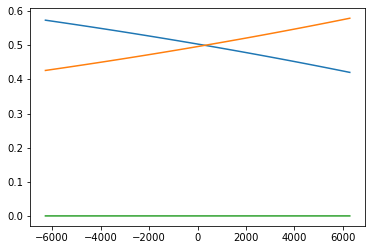

In [96]:
detuning_list = np.linspace(-1, 1, 31)*2e3*np.pi
# solution, mode_freq, gate_time, rabi_freq, detuning
plot_detuningScan(freq_sol, mode_freq, gate_time, rabi_freq, detuning_list, gateNum=1, ampOffset=1)
# plot_detuningScan(freq_sol, mode_freq, gate_time, detuning_list, gateNum=5, ampOffset=1.1)
# plot_detuningScan(freq_sol, mode_freq, gate_time, detuning_list, gateNum=9, ampOffset=1.1)
# plot_detuningScan(freq_sol, mode_freq, gate_time, detuning_list, ampOffset=1.05)

In [8]:
sim2 = ModulatedMSGate()

gate_time_2 = 240e-6
freq_sol_2_half = np.array([2256720.97160761, 2268465.85854298, 2286074.27451288,
       2267246.47544973, 2291406.19836854, 2294725.95324193,
       2283418.5698234 , 2282386.86542765, 2292520.70295315,
       2283464.68783479])#*2*np.pi
freq_sol_2 = np.append(freq_sol_2_half, np.flip(freq_sol_2_half))#*2*np.pi
# freq_sol_arobust = np.append(freq_sol_2, np.flip(freq_sol_2))#*2*np.pi
freq_sol_arobust = np.append(freq_sol_2, (2.3+2.33)*1e6-freq_sol_2)*2*np.pi
mode_freq = np.sort(np.array([2.3, 2.33]))*2e6*np.pi
rabi_freq_2 = 101316.446*0.1*2*np.pi/np.sqrt(2)

sim2.set_attr_fm(ion0,
                ion1,
                gate_time_2,
                freq_sol_arobust+20e3,#+1e3,
                rabi_freq_2,#/np.sqrt(2),
                mode_freq,
                posi)
nth = []#[0.0]*5
Gamma = []#[100.,100.,100.,100.,1500.]
print('Fidelity =',sim2.get_fidelity_fm(nth, Gamma, coherence_t = 2e3, Nsample=20)**2)
sim2.get_spin_fm(Nsample=20)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 4.29050780e-01-2.91679810e-17j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -2.39885074e-04+4.93705853e-01j]
 [ 0.00000000e+00+0.00000000e+00j  1.41760708e-03+1.57731114e-17j
  -2.39885074e-04+1.76576152e-17j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -2.39885074e-04-6.24941589e-18j
   1.41760708e-03-5.78975504e-18j  0.00000000e+00+0.00000000e+00j]
 [-2.39885074e-04-4.93705853e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  5.68114006e-01+1.96165334e-17j]]
Fidelity = 0.9922882455558769


array([[ 4.29052394e-01+3.19935007e-17j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, -2.40302913e-04+4.93704848e-01j],
       [ 0.00000000e+00+0.00000000e+00j,  1.58189087e-04+1.26379010e-17j,
        -2.40302913e-04+5.97238259e-04j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j, -2.40302913e-04-5.97238259e-04j,
         2.67792320e-03-5.89567748e-17j,  0.00000000e+00+0.00000000e+00j],
       [-2.40302913e-04-4.93704848e-01j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  5.68111493e-01+1.33685754e-17j]])

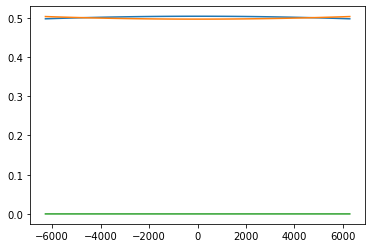

In [101]:
plot_detuningScan(freq_sol_arobust, mode_freq, gate_time_2, rabi_freq_2, detuning_list, gateNum=1, ampOffset=1, Nsample=20)

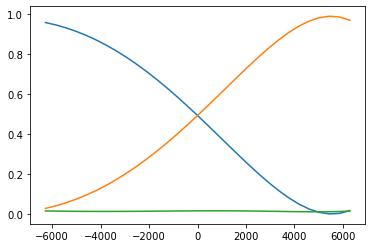

In [134]:
plot_detuningScan(freq_sol, mode_freq, gate_time, detuning_list, gateNum=5, ampOffset=1.0)

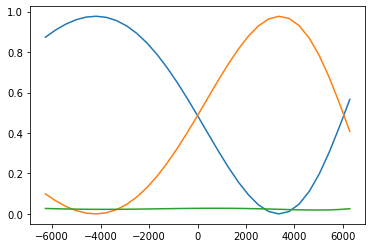

In [135]:
plot_detuningScan(freq_sol, mode_freq, gate_time, detuning_list, gateNum=9, ampOffset=1.0)

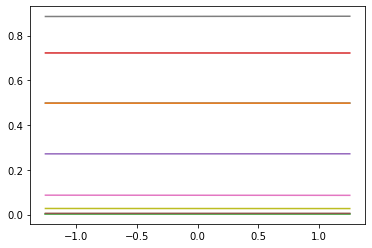

In [76]:
plot_detuningScan(freq_sol, mode_freq, gate_time, detuning_list, ampOffset=1.0)
plot_detuningScan(freq_sol, mode_freq, 5*gate_time, detuning_list, ampOffset=1.0)
plot_detuningScan(freq_sol, mode_freq, 9*gate_time, detuning_list, ampOffset=1.0)

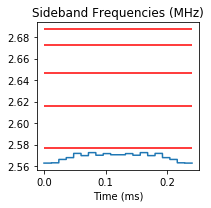

In [7]:
def plot_solution(solution, mode_freq, gate_time):
    plt.rcParams['figure.figsize'] = [3,3]
    for omega in mode_freq:
        plt.hlines(y=omega/(2*np.pi)/1e6,xmin=0,xmax=gate_time*1e3,color='r',linestyle='-')
  
    steps = 5000
    x = np.linspace(0,gate_time,steps*len(solution)*2)
    y = np.kron(np.append(solution, np.flip(solution)),np.ones(steps))
    plt.plot(x*1e3,y/(2*np.pi)/1e6)
    plt.title('Sideband Frequencies (MHz)')
    plt.xlabel('Time (ms)')
    plt.tight_layout()
    #plt.savefig('../+Python/freq_sol.pdf')
plot_solution(freq_sol, mode_freq, gate_time)

In [8]:
sim = ModulatedMSGate()

gate_time = 180e-6
freq_sol = np.array([16090357.93001755, 16121142.99551053, 16083261.81418849,
       16124716.61503399, 16082721.16788275, 16102789.54534561,
       16098945.97226923, 16090905.68257412, 16111698.68100802,
       16101592.99223338, 16104911.02899459, 16113958.35285445,
       16102405.95552298, 16101245.50116026, 16080791.84338749,
       16086653.19349161, 16122353.79961239, 16103724.46630204,
       16088776.24675219, 16105366.94910051])
phase_sol = np.array([-2.65386566e+02,  3.32540514e-01, -2.83544764e-01, -5.22290512e-01,
        2.87665476e-01,  3.28931423e-01,  1.48801535e+00,  4.39223573e-02,
       -5.80866048e+00,  3.15695320e-02, -1.91726740e-01,  7.34199587e-01,
       -4.04035865e-01,  3.26240451e-01,  1.39248308e+00,  2.35129319e+00,
       -1.31046198e+00, -3.93546026e-01,  1.68129596e-01, -4.93702966e-01])
mode_freq = np.sort(np.array([2.68847, 2.67426, 2.64638, 2.61652, 2.57733])+0.00)*2e6*np.pi
rabi_freq = (8186.931)* np.pi*2

ion0 = 2
ion1 = 3
posi = np.array([-1.95632,-0.941502,-0.0330485,0.875784,1.89247])

sim.set_attr_fmpm(ion0,
                  ion1,
                  gate_time,
                  freq_sol,
                  phase_sol,
                  rabi_freq,
                  mode_freq,
                  posi)
nth = [0.0000001]*5
Gamma = [100.,100.,100.,100.,1500.]
print(sim.get_fidelity_pm(nth = nth, Gamma = Gamma, coherence_t = 12*gate_time)**2)
# sim.get_trajectory(coherence_t = 2e-3)

....................
....................
....................
....................
....................
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.48893664+0.j          0.        +0.j          0.        +0.j
  -0.00909822+0.48509315j]
 [ 0.        +0.j          0.01135214+0.j         -0.00909822+0.0039999j
   0.        +0.j        ]
 [ 0.        +0.j         -0.00909822-0.0039999j   0.01124913+0.j
   0.        +0.j        ]
 [-0.00909822-0.48509315j  0.        +0.j          0.        +0.j
   0.48846209+0.j        ]]
0.9737925307283308


In [9]:
qt.ket2dm(qt.Qobj(np.array([[0.5+0.5j,0,0,0.5-0.5j]])))

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.5+0.j  0. +0.j  0. +0.j  0. -0.5j]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.5j 0. +0.j  0. +0.j  0.5+0.j ]]

In [10]:
qt.ket2dm(qt.Qobj(np.array([[0.5-0.5j,0,0,0.5+0.5j]])))

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.5+0.j  0. +0.j  0. +0.j  0. +0.5j]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. -0.5j 0. +0.j  0. +0.j  0.5+0.j ]]

In [11]:
init = qt.Qobj(((qt.tensor(qt.fock(2,0),qt.fock(2,0)))).full())
ms = qt.Qobj(1/np.sqrt(2)*np.array([[1,0,0,np.exp(1j*(np.pi*(-1/2)))],[0,1,-1j,0],[0,-1j,1,0],[np.exp(-1j*np.pi*(-1/2)),0,0,1]]))
ms*init

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.70710678+0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.70710678j]]

In [13]:
sim = ModulatedMSGate()

gate_time = 240e-6
freq_sol = np.array([2549398.722147539,2604200.122435702,2608012.2591987625,2598954.1476000124,
                     2606521.0286001167,2603975.132232204,2589510.42676525,2573712.185632656,
                     2604139.359990446,2579804.7040931405])*np.pi*2
mode_freq = np.sort(np.array([2.580038,2.61763716,2.64862026,2.67487638,2.69104833])+0.00)*2000000*np.pi
rabi_freq = (5432.992)* np.pi*2

ion0 = 1
ion1 = 3
posi = np.array([-1.95632,-0.941502,-0.0330485,0.875784,1.89247])

sim.set_attr_fm(ion0,
                ion1,
                gate_time,
                freq_sol,
                rabi_freq,
                mode_freq,
                posi)
nth = [0.0000001]*5
Gamma = [100.,100.,100.,100.,1500.]
print(sim.get_fidelity_pm(nth = nth, Gamma = Gamma, coherence_t = 2e-3)**2)
sim.get_trajectory(coherence_t = 2e-3)

....................
....................
....................
....................
....................
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[4.89228689e-01+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 1.84331915e-04+4.87275222e-01j]
 [0.00000000e+00+0.00000000e+00j 1.10417675e-02+0.00000000e+00j
  1.84331915e-04+3.06960494e-05j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 1.84331915e-04-3.06960494e-05j
  1.10411990e-02+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [1.84331915e-04-4.87275222e-01j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 4.88688345e-01+0.00000000e+00j]]
0.976233759860616


TypeError: must be real number, not Qobj

<Figure size 216x216 with 0 Axes>

In [14]:
sim = ModulatedMSGate()

gate_time = 240e-6
freq_sol = np.array([2559277.9742404916,2594725.4337062244,2576597.600680009,2612313.7705313666,2573855.623627272,2589990.5496374364,2585207.6946802004,2585933.846031229,2565889.748553727,2598763.800983351])*np.pi*2
mode_freq = np.sort(np.array([2.580038,2.61763716,2.64862026,2.67487638,2.69104833])+0.00)*2000000*np.pi
rabi_freq = (5255.824)* np.pi*2

ion0 = 1
ion1 = 3
posi = np.array([-1.95632,-0.941502,-0.0330485,0.875784,1.89247])

sim.set_attr_fm(ion0,
                ion1,
                gate_time,
                freq_sol,
                rabi_freq,
                mode_freq,
                posi)

nth = [0.0000001]*5
Gamma = [100.,100.,100.,100.,1500.]
print(sim.get_fidelity_pm()**2)
# sim.get_trajectory(coherence_t = 2e-3)

....................
....................
....................
....................
....................
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[4.99986213e-01+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 7.49350395e-06+4.99988927e-01j]
 [0.00000000e+00+0.00000000e+00j 9.89913630e-06+0.00000000e+00j
  7.49350395e-06+4.25943921e-09j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 7.49350395e-06-4.25943918e-09j
  9.90781425e-06+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [7.49350395e-06-4.99988927e-01j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 4.99993980e-01+0.00000000e+00j]]
0.9999790414924277


In [15]:
eigen_state = (qt.tensor(qt.sigmap(),qt.qeye(2)) - qt.tensor(qt.sigmam(),qt.qeye(2))+\
                       qt.tensor(qt.qeye(2),qt.sigmap()) - qt.tensor(qt.qeye(2),qt.sigmam())).eigenstates()

In [16]:
eigen_state[1][1]

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0. -0.5j]
 [0.5+0.j ]
 [0.5+0.j ]
 [0. +0.5j]]

## 7 ions

* 'gate_time': 
        0.00024
* 'freq_sol': 
       array([15436839.7671915 , 15565472.36919696, 15691291.79163438,
       15519090.07055998, 15162578.42902212, 15513966.07538832,
       15660603.75676547, 15588867.87669045, 15606608.17940207,
       15616505.4436348 ])
* 'ion0': 
        3
* 'ion1': 
        4
* 'rabi_freq': 
        33724.52573260249
* 'mode_freq': 
        array([15642262.2611385 , 15890592.84536157, 16108793.41975371,
       16302227.87677981, 16462684.15607523, 16592792.96449624,
       16676099.95919224]), 
* 'posi': 
        array([-2.72249  , -1.72576  , -0.861002 , -0.0405528,  0.780617 ,
        1.64702  ,  2.64678  ])

In [17]:
import pickle
sim = ModulatedMSGate()
fm_sol = pickle.load(open('fm.solution','rb'))
gate_time = fm_sol['gate_time']
freq_sol = fm_sol['freq_sol']
mode_freq = fm_sol['mode_freq']
# mode_freq = np.append([mode_freq[0]-1e3*2*np.pi],mode_freq)
rabi_freq = fm_sol['rabi_freq']

ion0 = fm_sol['ion0']
ion1 = fm_sol['ion1']
posi = fm_sol['posi']

sim.set_attr_fm(ion0,
                ion1,
                gate_time,
                freq_sol,
                rabi_freq,
                mode_freq,
                posi)

# sim.eta = np.concatenate((np.ones(7).reshape(-1,1)*0.5,sim.eta),axis = 1)

nth = [0.0000001]*(posi.shape[0])
Gamma = [100.]*(posi.shape[0]-1) +[1500.]*1
print(sim.get_fidelity_pm(coherence_t = 8e-3)**2)
# print(sim.get_fidelity_pm()**2)
sim.get_trajectory(coherence_t = 2e-3)

FileNotFoundError: [Errno 2] No such file or directory: 'fm.solution'

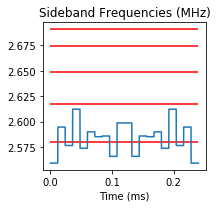

In [18]:
plot_solution(freq_sol, mode_freq, gate_time)

In [19]:
qt.Qobj([[0.77315495+0.00000000e+00j, 0.        +0.00000000e+00j,
  0.        +0.00000000e+00j, 0.00235853+4.14088121e-01j],
 [0.        +0.00000000e+00j, 0.00253234+0.00000000e+00j,
  0.00235853-1.78441467e-05j, 0.        +0.00000000e+00j],
 [0.        +0.00000000e+00j, 0.00235853+1.78441467e-05j,
  0.00250939+0.00000000e+00j, 0.        +0.00000000e+00j],
 [0.00235853-4.14088121e-01j, 0.        +0.00000000e+00j,
  0.        +0.00000000e+00j, 0.22180332+0.00000000e+00j]])

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.77315495+0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.00235853+4.14088121e-01j]
 [0.        +0.00000000e+00j 0.00253234+0.00000000e+00j
  0.00235853-1.78441467e-05j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.00235853+1.78441467e-05j
  0.00250939+0.00000000e+00j 0.        +0.00000000e+00j]
 [0.00235853-4.14088121e-01j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.22180332+0.00000000e+00j]]

In [20]:
np.ones(7).reshape(-1,1)*0.005

array([[0.005],
       [0.005],
       [0.005],
       [0.005],
       [0.005],
       [0.005],
       [0.005]])

In [23]:
import numpy as np
def _get_coupling(beta = 9.48):
    posi = np.array([-2.72249, -1.72576, -0.861002, -0.0405528, 0.780617, 1.64702,2.64678])
    n = posi.shape[0]
    A = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            if i == j:
                A[i][j] = beta**2 - np.sum(np.abs(posi[j]-posi[:j])**(-3)) - np.sum(np.abs(posi[j]-posi[j+1:])**(-3))
            else:
                A[i][j] = 1. / np.abs(posi[i]-posi[j]) ** 3
    w, v = linalg.eig(A)
    idx = w.argsort()  
    v = v[:,idx]
    return v, w, A

In [26]:
v.T

array([[ 0.02383825, -0.17770323,  0.49365702, -0.67628678,  0.48629137,
        -0.17260563,  0.022809  ],
       [-0.08906695,  0.41763578, -0.56323838, -0.00736993,  0.5679881 ,
        -0.41259793,  0.08664931],
       [-0.21866794,  0.57081604, -0.10918964, -0.47741702, -0.12117209,
         0.570616  , -0.21498535],
       [ 0.39865046, -0.4370024 , -0.38700803, -0.00499964,  0.38275885,
         0.44372255, -0.39612178],
       [ 0.5562568 , -0.02388892, -0.31981685, -0.41445271, -0.32451375,
        -0.0301249 ,  0.55654033],
       [-0.57661268, -0.36574861, -0.17952079, -0.00129617,  0.17764259,
         0.36566827,  0.5798674 ],
       [ 0.37796447,  0.37796447,  0.37796447,  0.37796447,  0.37796447,
         0.37796447,  0.37796447]])

In [25]:
v,w,a = _get_coupling()

In [27]:
xx = qt.Qobj(v).dag()

In [28]:
vv = np.zeros([7,7])
for i in range(7):
    vv[i,:] = v.T[6-i,:]
qt.Qobj(vv)

Quantum object: dims = [[7], [7]], shape = (7, 7), type = oper, isherm = False
Qobj data =
[[ 0.37796447  0.37796447  0.37796447  0.37796447  0.37796447  0.37796447
   0.37796447]
 [-0.57661268 -0.36574861 -0.17952079 -0.00129617  0.17764259  0.36566827
   0.5798674 ]
 [ 0.5562568  -0.02388892 -0.31981685 -0.41445271 -0.32451375 -0.0301249
   0.55654033]
 [ 0.39865046 -0.4370024  -0.38700803 -0.00499964  0.38275885  0.44372255
  -0.39612178]
 [-0.21866794  0.57081604 -0.10918964 -0.47741702 -0.12117209  0.570616
  -0.21498535]
 [-0.08906695  0.41763578 -0.56323838 -0.00736993  0.5679881  -0.41259793
   0.08664931]
 [ 0.02383825 -0.17770323  0.49365702 -0.67628678  0.48629137 -0.17260563
   0.022809  ]]

In [29]:
qt.create(20) + qt.destroy(20)

Quantum object: dims = [[20], [20]], shape = (20, 20), type = oper, isherm = True
Qobj data =
[[0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.         1.41421356 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         1.41421356 0.         1.73205081 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.73205081 0.         2.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         2.         0.         2.23606798
  0.         0.   

In [30]:
hbar=1.05e-34
mass=171*1.67e-27
omega=3.1e6*np.pi*2
eta=np.sqrt(hbar/(2*mass*omega))
Nmax=1000
x=(qt.create(Nmax)+qt.destroy(Nmax))
ns = qt.thermal_dm(Nmax,20)
print (np.sqrt((x*x*ns).tr())*eta)

1.9671818473758624e-08


In [31]:
1/35*180

5.142857142857142

In [11]:
def get_coupling(n = 5, beta = 9.48):
    posi = np.array([-2., -1.,0., 1., 2.])
    n = posi.shape[0]
    A = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            if i == j:
                A[i][j] = beta**2 - np.sum(np.abs(posi[j]-posi[:j])**(-3)) - np.sum(np.abs(posi[j]-posi[j+1:])**(-3))
            else:
                A[i][j] = 1. / np.abs(posi[i]-posi[j]) ** 3
    w, v = linalg.eig(A)
    idx = w.argsort()  
    v = v[:,idx]
    return v

get_coupling()

array([[-1.72308939e-01, -3.55728185e-01,  5.19913098e-01,
         6.11111658e-01,  4.47213595e-01],
       [ 5.02392969e-01,  6.11111658e-01, -2.18177232e-01,
         3.55728185e-01,  4.47213595e-01],
       [-6.60168061e-01,  3.77943113e-14, -6.03471732e-01,
        -7.57281061e-15,  4.47213595e-01],
       [ 5.02392969e-01, -6.11111658e-01, -2.18177232e-01,
        -3.55728185e-01,  4.47213595e-01],
       [-1.72308939e-01,  3.55728185e-01,  5.19913098e-01,
        -6.11111658e-01,  4.47213595e-01]])